# FP-Tree

This notebook contains an implementation of the FP-tree algorithm for association rule mining.

## Sampling the dataset

In this demonstration, the transaction data is playlists belonging to the [Spotify Million Playlist Dataset](https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge), and the items are artists.

Since the original dataset is 1 million playlists long, we will select a random sample of 1000 playlists for running our experiment.

In [1]:
import json

In [2]:
data_file = open("preprocessed-data/filtered-data.json")
data = json.load(data_file)
info_file = open("preprocessed-data/artist-info.json")
info = json.load(info_file)

In [3]:
TOTAL_PLAYLISTS = len(data)
NUM_ARTISTS = len(info)

In [4]:
NUM_PLAYLISTS = 1000

In [5]:
import random

In [6]:
random.seed(30)

In [7]:
selected_playlists = random.sample(range(TOTAL_PLAYLISTS), NUM_PLAYLISTS)
sample = []
for i in selected_playlists:
    sample.append(data[i])

## Constructing the tree

In [8]:
class Node:
    def __init__(self, artist):
        self.artist = artist
        self.freq = 0
        self.next = None
        self.down = []
        self.visited = False

In [9]:
pointers = []
for i in range(NUM_ARTISTS):
    pointers.append(Node(i))

In [10]:
for i in range(NUM_PLAYLISTS):
    playlist = sample[i]
    active = None
    for item in playlist:
        if active is None:
            active = pointers[item]
            while active.next is not None:
                active = active.next
        else:
            found = False
            for child in active.down:
                if child.artist == item:
                    active = child
                    found = True
                    break
            if not found:
                new = Node(item)
                new.next = pointers[item]
                pointers[item] = new
                active.down.append(new)
                active = new
        active.freq += 1

## Finding conditional pattern bases

In [11]:
patterns = []
for i in range(NUM_ARTISTS):
    patterns.append([])

In [12]:
def dfs(active, base):
    active.visited = True
    patterns[active.artist].append((tuple(base), active.freq))
    base.append(active.artist)
    for child in active.down:
        dfs(child, base)
    base.pop()

In [13]:
for i in range(NUM_ARTISTS):
    active = pointers[i]
    while active is not None:
        if not active.visited:
            dfs(active, [])
        active = active.next

## Generating the conditional FP-tree

In [14]:
def conditional_gen(i):
    freq = []
    for j in range(i):
        freq.append(0)
    total = 0
    for base, count in patterns[i]:
        total += count
        for item in base:
            freq[item] += count
    sub = []
    for j in range(i):
        if (total != 0) and ((freq[j] / total) >= 0.9):
            sub.append(j)
    return sub


## Finding frequent patterns

In [15]:
def freq_gen():
    frequent = []
    for i in range(NUM_ARTISTS):
        conditional = conditional_gen(i)
        n = len(conditional)
        if n == 0:
            continue
        for j in range(1, 2 ** n):
            patt = []
            p = j
            for k in range(n):
                if p % 2:
                    patt.append(conditional[k])
                p = int(p / 2)
            patt.append(i)
            frequent.append(tuple(patt))
    return frequent

## Mining rules

In [16]:
def support(part):
    n = len(part)
    count = 0
    for playlist in sample:
        i = 0
        for item in playlist:
            if item == part[i]:
                i += 1
            if i == n:
                break
        if i == n:
            count += 1
    return count

In [17]:
def rule_gen(min_sup, min_con_lif, is_con):
    rules = []
    frequent = freq_gen()
    count = 0
    for i in range(len(frequent)):
        subset = frequent[i]
        n = len(subset)
        for j in range(1, (2 ** n) - 1):
            left, right = [], []
            p = j
            for k in range(n):
                if p % 2:
                    left.append(subset[k])
                else:
                    right.append(subset[k])
                p = int(p / 2)
            num, denom = support(subset), support(left)
            count += 1
            if is_con:
                if (not (denom == 0)) and ((num / NUM_PLAYLISTS) >= min_sup) and ((num / denom) >= min_con_lif):
                    rules.append((tuple(left), tuple(right), num / NUM_PLAYLISTS, num / denom))
            else:
                add = support(right)
                if (not (denom == 0)) and (not (add == 0)) and ((num / NUM_PLAYLISTS) >= min_sup) and ((num / (denom * add)) >= min_con_lif):
                    rules.append((tuple(left), tuple(right), num / NUM_PLAYLISTS, num / (denom * add)))
    return rules

## Rule generation with minimum confidence

In [18]:
rules = rule_gen(0.005, 0.3, True)
print(len(rules))

251


In [19]:
def view_rules(rules, limit, is_con):
    if is_con:
        measure = "Confidence"
    else:
        measure = "Lift"
    limit = min(limit, len(rules))
    selected = random.sample(range(len(rules)), limit)
    for idx in selected:
        rule = rules[idx]
        left, right = ', '.join([info[x]["name"] for x in rule[0]]), ', '.join([info[x]["name"] for x in rule[1]])
        print("Support = " + ("%.3f" % rule[2]) + "; " + measure + " = " + ("%.3f" % rule[3]) + "; {" + left + "} -> {" + right + "}")

In [20]:
view_rules(rules, 20, True)

Support = 0.010; Confidence = 0.333; {Blake Shelton, Tim McGraw} -> {Chris Young}
Support = 0.005; Confidence = 0.455; {George Strait, Brooks & Dunn} -> {Eric Church, Justin Moore}
Support = 0.008; Confidence = 1.000; {Rihanna, Swedish House Mafia} -> {Calvin Harris, David Guetta}
Support = 0.006; Confidence = 1.000; {Drake, SZA, Majid Jordan} -> {The Weeknd}
Support = 0.005; Confidence = 1.000; {Justin Moore} -> {Eric Church}
Support = 0.009; Confidence = 1.000; {Travis Scott, 21 Savage, Smokepurpp} -> {Post Malone, Lil Uzi Vert}
Support = 0.008; Confidence = 1.000; {Brothers Osborne} -> {Luke Bryan}
Support = 0.005; Confidence = 1.000; {George Strait, Brooks & Dunn, Justin Moore} -> {Eric Church}
Support = 0.008; Confidence = 1.000; {Rihanna, Swedish House Mafia} -> {Calvin Harris}
Support = 0.012; Confidence = 0.923; {Metro Boomin} -> {Drake, Lil Uzi Vert, 21 Savage}
Support = 0.015; Confidence = 1.000; {Post Malone, Tee Grizzley} -> {21 Savage}
Support = 0.008; Confidence = 0.308; 

## Rule generation with minimum lift

In [21]:
rules = rule_gen(0.005, 0.01, False)
print(len(rules))

336


In [22]:
view_rules(rules, 20, False)

Support = 0.009; Lift = 0.021; {Lil Uzi Vert, 21 Savage} -> {Post Malone, Travis Scott, Smokepurpp}
Support = 0.006; Lift = 0.062; {Drake, SZA} -> {Majid Jordan}
Support = 0.009; Lift = 0.013; {Lil Uzi Vert, 21 Savage, Smokepurpp} -> {Travis Scott}
Support = 0.008; Lift = 0.019; {Zac Brown Band} -> {Luke Bryan, Brothers Osborne}
Support = 0.005; Lift = 0.083; {Eric Church, Brooks & Dunn} -> {Justin Moore}
Support = 0.009; Lift = 0.017; {21 Savage} -> {Lil Uzi Vert, Smokepurpp}
Support = 0.009; Lift = 0.013; {Travis Scott} -> {Post Malone, 21 Savage, Smokepurpp}
Support = 0.009; Lift = 0.032; {Travis Scott, 21 Savage} -> {Post Malone, Smokepurpp}
Support = 0.009; Lift = 0.013; {Post Malone, Lil Uzi Vert, 21 Savage, Smokepurpp} -> {Travis Scott}
Support = 0.010; Lift = 0.028; {Blake Shelton, Tim McGraw} -> {Chris Young}
Support = 0.013; Lift = 0.017; {Lil Uzi Vert, Metro Boomin} -> {21 Savage}
Support = 0.009; Lift = 0.026; {Travis Scott, Lil Uzi Vert, Smokepurpp} -> {Post Malone, 21 Sav

## Generating recommendations from association rules

In [23]:
def extend(playlist, rules):
    additions = []
    for rule in rules:
        left, right = rule[0], rule[1]
        idx = 0
        for artist in playlist:
            if artist == left[idx]:
                idx += 1
            if idx == len(left):
                break
        if idx == len(left):
            for artist in right:
                if (artist not in playlist) and (artist not in additions):
                    additions.append(artist)
    playlist.extend(additions)
    sorted(playlist)
    return playlist

In [24]:
def print_playlist(playlist):
    for idx, item in enumerate(playlist):
        print(f"{idx + 1}:\t{info[item]['name']}")

In [25]:
sample_playlist = [0, 38, 57, 297, 345]
print_playlist(sample_playlist)

1:	Drake
2:	Travis Scott
3:	Flume
4:	Playboi Carti
5:	SZA


In [26]:
extended_sample_playlist = extend(sample_playlist, rules)
print_playlist(extended_sample_playlist)

1:	Drake
2:	Travis Scott
3:	Flume
4:	Playboi Carti
5:	SZA
6:	Smokepurpp
7:	Post Malone
8:	Lil Uzi Vert
9:	21 Savage
10:	Majid Jordan
11:	The Weeknd


## Varying hyperparameters

In [27]:
import matplotlib.pyplot as plt

In [28]:
START_MIN_CON = 0.1
END_MIN_CON = 0.5
STEP_MIN_CON = 0.05

[0.1, 0.15000000000000002, 0.2, 0.25, 0.3, 0.35, 0.39999999999999997, 0.44999999999999996, 0.49999999999999994] [383, 346, 313, 287, 251, 242, 237, 228, 220]


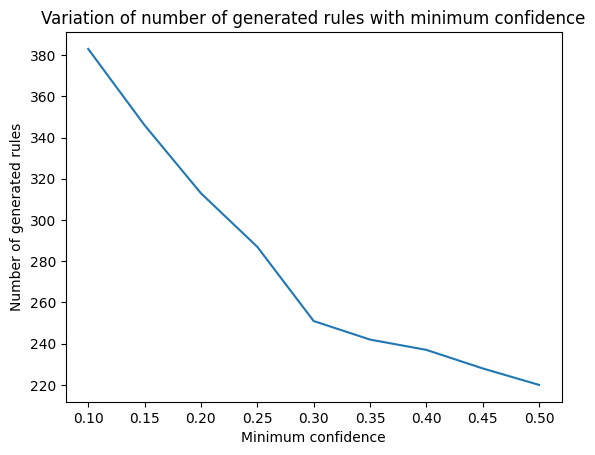

In [29]:
x, y = [], []
min_con = START_MIN_CON
while min_con <= END_MIN_CON:
    rules = rule_gen(0.005, min_con, True)
    x.append(min_con)
    y.append(len(rules))
    min_con += STEP_MIN_CON
plt.plot(x, y)
print(x, y)
plt.title("Variation of number of generated rules with minimum confidence")
plt.xlabel("Minimum confidence")
plt.ylabel("Number of generated rules")
plt.show()

In [30]:
START_MIN_LIF = 0.005
END_MIN_LIF = 0.03
STEP_MIN_LIF = 0.005

[0.005, 0.01, 0.015, 0.02, 0.025] [388, 336, 260, 204, 136]


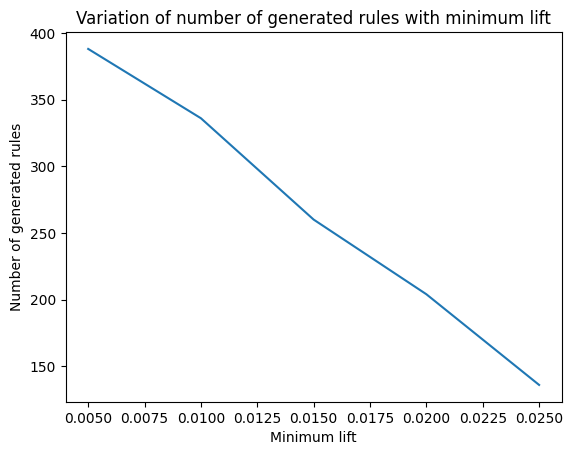

In [31]:
x, y = [], []
min_lif = START_MIN_LIF
while min_lif <= END_MIN_LIF:
    rules = rule_gen(0.005, min_lif, False)
    x.append(min_lif)
    y.append(len(rules))
    min_lif += STEP_MIN_LIF
plt.plot(x, y)
print(x, y)
plt.title("Variation of number of generated rules with minimum lift")
plt.xlabel("Minimum lift")
plt.ylabel("Number of generated rules")
plt.show()